# BERT Fine-Tuning

This notebook implements BERT fine-tuning for text classification using HuggingFace Transformers.

In [98]:
import sys
import os
# Add project root to Python path
project_root = os.path.dirname(os.getcwd())
sys.path.insert(0, project_root)

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import get_scheduler
import numpy as np
from src.data_utils import load_text_classification_data
from src.text_preprocess import basic_clean
from src.model.bert_model import BertClassifier, get_tokenizer
from src.train_nn import train_epoch_with_scheduler, eval_epoch_bert
from src.evaluate import evaluate_classification

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


## 1. Load Data

In [99]:
# Load data
train_texts, train_labels, label2id, id2label = load_text_classification_data('train')
val_texts, val_labels, _, _ = load_text_classification_data('val')
test_texts, test_labels, _, _ = load_text_classification_data('test')

# BERT 使用原始文本，仅去掉首尾空白；TF-IDF/CNN 仍可单独使用 basic_clean
train_texts_clean = [text.strip() for text in train_texts]
val_texts_clean = [text.strip() for text in val_texts]
test_texts_clean = [text.strip() for text in test_texts]

print(f"Training samples: {len(train_texts_clean)}")
print(f"Validation samples: {len(val_texts_clean)}")
print(f"Test samples: {len(test_texts_clean)}")
print(f"Label mapping: {label2id}")


Training samples: 19782
Validation samples: 4239
Test samples: 4240
Label mapping: {'high': 0, 'low': 1, 'medium': 2}


## 2. Initialize Tokenizer

In [100]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_path = "/root/AI_support_tickets/src/model/distilbert-base-uncased"  # 用上一步确认过的那个

tokenizer = AutoTokenizer.from_pretrained(model_path, local_files_only=True)
model = AutoModelForSequenceClassification.from_pretrained(model_path, local_files_only=True)


max_length = 512  # 修改: 从256提升到512以包含更多文本信息（平均文本长度411字符）

print(f"Tokenizer loaded: {model_path}")
print(f"Max length: {max_length}")

Tokenizer loaded: /root/AI_support_tickets/src/model/distilbert-base-uncased
Max length: 512


## 3. Create Dataset Class

In [101]:
class BertDataset(Dataset):
    """Dataset for BERT text classification."""
    
    def __init__(self, texts, labels, tokenizer, max_length=512):  # 修改: 默认值从256改为512
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        # Tokenize
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].squeeze(0),  # Remove batch dimension: (1, seq_len) -> (seq_len,)
            'attention_mask': encoding['attention_mask'].squeeze(0),  # Remove batch dimension
            'labels': torch.tensor(label, dtype=torch.long)
        }

## 4. Create DataLoaders

In [102]:
# Create datasets
train_dataset = BertDataset(train_texts_clean, train_labels, tokenizer, max_length=max_length)
val_dataset = BertDataset(val_texts_clean, val_labels, tokenizer, max_length=max_length)
test_dataset = BertDataset(test_texts_clean, test_labels, tokenizer, max_length=max_length)

# Create dataloaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 1237
Val batches: 265
Test batches: 265


In [103]:
import torch

def freeze_all_bert(bert):
    for p in bert.parameters():
        p.requires_grad = False

def unfreeze_last_n_layers(bert, n):
    # DistilBERT: bert.transformer.layer
    if hasattr(bert, "transformer") and hasattr(bert.transformer, "layer"):
        layers = bert.transformer.layer
    # BERT/RoBERTa: bert.encoder.layer
    elif hasattr(bert, "encoder") and hasattr(bert.encoder, "layer"):
        layers = bert.encoder.layer
    else:
        raise ValueError("Cannot locate transformer layers for partial unfreeze.")

    n = min(n, len(layers))
    for layer in layers[-n:]:
        for p in layer.parameters():
            p.requires_grad = True
    return len(layers), n

def print_trainable(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("Total params:", f"{total:,}")
    print("Trainable params:", f"{trainable:,}")
    for name, p in model.named_parameters():
        if p.requires_grad:
            print("TRAIN:", name, p.numel())


## 5. Initialize Model

In [104]:
# Initialize BERT classifier
model = BertClassifier(
    model_name=model_path,
    num_classes=3,
    dropout=0.3,
    freeze_bert= False
).to(device)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Model parameters: 66,365,187
Trainable parameters: 66,365,187


## 6. Setup Training

In [105]:
# # ===== A2.5: Partial Unfreeze + Different LRs (encoder vs head) =====
# unfreeze_last_n = 2         # 建议先 2
# lr_encoder = 2e-5           # encoder 小 lr
# lr_head = 1e-3              # head 大 lr（你刚才在 A2 用过）
# weight_decay = 0.01

# # 1) 先确保 encoder 全冻
# freeze_all_bert(model.bert)

# # 2) 解冻最后 N 层
# total_layers, used_n = unfreeze_last_n_layers(model.bert, unfreeze_last_n)
# print(f"Partial unfreeze: last {used_n}/{total_layers} layers")

# # 3) 确保分类头可训练
# for p in model.classifier.parameters():
#     p.requires_grad = True

# print_trainable(model)

# # 4) 两组参数：encoder(解冻部分) + head
# encoder_params = [p for p in model.bert.parameters() if p.requires_grad]
# head_params = list(model.classifier.parameters())

# optimizer = torch.optim.AdamW(
#     [
#         {"params": encoder_params, "lr": lr_encoder},
#         {"params": head_params, "lr": lr_head},
#     ],
#     weight_decay=weight_decay
# )

# # ===== loss（你原来的保持不变）=====
# class_counts = np.bincount(train_labels)
# class_weights = (len(train_labels) / (len(class_counts) * class_counts)).astype(np.float32)
# class_weights_tensor = torch.tensor(class_weights, device=device)
# criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# # ===== scheduler（你原来的保持不变）=====
# num_epochs = 10
# num_training_steps = len(train_loader) * num_epochs
# num_warmup_steps = int(0.1 * num_training_steps)

# scheduler = get_scheduler(
#     "cosine",
#     optimizer,
#     num_warmup_steps=num_warmup_steps,
#     num_training_steps=num_training_steps
# )

# print(f"Training for {num_epochs} epochs")
# print(f"Total steps: {num_training_steps}")
# print(f"Warmup steps: {num_warmup_steps}")
# print("Param groups LRs:", [g["lr"] for g in optimizer.param_groups])
# print(f"Class weights: {class_weights.tolist()}")


In [106]:
# Setup optimizer and loss
# 修改: 降低学习率从5e-5到2e-5，使用更稳定的训练
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

class_counts = np.bincount(train_labels)
class_weights = (len(train_labels) / (len(class_counts) * class_counts)).astype(np.float32)
class_weights_tensor = torch.tensor(class_weights, device=device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Setup learning rate scheduler with warmup
# 修改: 增加训练轮数从3到10，使用cosine调度器
num_epochs = 10
num_training_steps = len(train_loader) * num_epochs
num_warmup_steps = int(0.1 * num_training_steps)

scheduler = get_scheduler(
    "cosine",  # 修改: 从linear改为cosine，避免学习率过早归零
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

print(f"Training for {num_epochs} epochs")
print(f"Total steps: {num_training_steps}")
print(f"Warmup steps: {num_warmup_steps}")
print(f"Initial learning rate: {optimizer.param_groups[0]['lr']:.2e}")
print(f"Class weights: {class_weights.tolist()}")


Training for 10 epochs
Total steps: 12370
Warmup steps: 1237
Initial learning rate: 0.00e+00
Class weights: [0.8565860986709595, 1.630967140197754, 0.8200472593307495]


## 7. Custom Training Loop with Scheduler

In [107]:
# Training and evaluation functions are now imported from src.train_nn
# train_epoch_with_scheduler and eval_epoch_bert are available

## 8. Training Loop

In [108]:
# Training loop with Early Stopping
best_val_acc = 0
best_val_loss = float('inf')
patience = 3
patience_counter = 0
best_model_state = None

print("Starting training with Early Stopping (patience=3)...")
print("=" * 60)

for epoch in range(num_epochs):
    # Train
    train_loss, train_acc = train_epoch_with_scheduler(
        train_loader, model, criterion, optimizer, scheduler, device
    )
    
    # Validate
    val_loss, val_acc, _, _ = eval_epoch_bert(val_loader, model, criterion, device)
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print(f"  Learning Rate: {scheduler.get_last_lr()[0]:.2e}")
    
    # Early Stopping logic
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict().copy()
        print(f"  ✓ New best validation accuracy: {best_val_acc:.4f}")
    else:
        patience_counter += 1
        print(f"  - No improvement (patience: {patience_counter}/{patience})")
        
        if patience_counter >= patience:
            print(f"\n⚠ Early stopping triggered at epoch {epoch+1}")
            print(f"Best validation accuracy: {best_val_acc:.4f} (loss: {best_val_loss:.4f})")
            break
    
    print()

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\n✓ Loaded best model with validation accuracy: {best_val_acc:.4f}")
else:
    print("\n⚠ No improvement found, using final model")

Starting training with Early Stopping (patience=3)...


Epoch 1/10
  Train Loss: 1.0864, Train Acc: 0.3867
  Val Loss: 1.0456, Val Acc: 0.4824
  Learning Rate: 2.00e-05
  ✓ New best validation accuracy: 0.4824

Epoch 2/10
  Train Loss: 0.9892, Train Acc: 0.4909
  Val Loss: 0.9458, Val Acc: 0.5497
  Learning Rate: 1.94e-05
  ✓ New best validation accuracy: 0.5497

Epoch 3/10
  Train Loss: 0.7772, Train Acc: 0.6426
  Val Loss: 0.8801, Val Acc: 0.6303
  Learning Rate: 1.77e-05
  ✓ New best validation accuracy: 0.6303

Epoch 4/10
  Train Loss: 0.5395, Train Acc: 0.7660
  Val Loss: 0.8302, Val Acc: 0.6848
  Learning Rate: 1.50e-05
  ✓ New best validation accuracy: 0.6848

Epoch 5/10
  Train Loss: 0.3637, Train Acc: 0.8506
  Val Loss: 0.9421, Val Acc: 0.7207
  Learning Rate: 1.17e-05
  ✓ New best validation accuracy: 0.7207

Epoch 6/10
  Train Loss: 0.2371, Train Acc: 0.9031
  Val Loss: 1.0159, Val Acc: 0.7278
  Learning Rate: 8.26e-06
  ✓ New best validation accuracy: 0.7278

Epoch 7/10
  Train Loss: 0.1655, Train Acc: 0.9364
  Val Loss: 1.2601,

## 9. Evaluate on Validation Set

In [109]:
# Evaluate on validation set
val_loss, val_acc, val_pred, val_true = eval_epoch_bert(val_loader, model, criterion, device)

val_results = evaluate_classification(val_true, val_pred)
print("Validation Results:")
print(f"Accuracy: {val_results['accuracy']:.4f}")
print(f"F1 Macro: {val_results['f1_macro']:.4f}")
print("\nClassification Report:")
print(val_results['report'])

Validation Results:
Accuracy: 0.7547
F1 Macro: 0.7471

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.79      0.78      1615
           1       0.75      0.67      0.71       855
           2       0.74      0.77      0.75      1769

    accuracy                           0.75      4239
   macro avg       0.75      0.74      0.75      4239
weighted avg       0.75      0.75      0.75      4239



## 10. Evaluate on Test Set

In [110]:
# Evaluate on test set
test_loss, test_acc, test_pred, test_true = eval_epoch_bert(test_loader, model, criterion, device)

test_results = evaluate_classification(test_true, test_pred)
print("Test Results:")
print(f"Accuracy: {test_results['accuracy']:.4f}")
print(f"F1 Macro: {test_results['f1_macro']:.4f}")
print("\nClassification Report:")
print(test_results['report'])

Test Results:
Accuracy: 0.7559
F1 Macro: 0.7460

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.81      0.79      1604
           1       0.75      0.65      0.70       876
           2       0.75      0.76      0.75      1760

    accuracy                           0.76      4240
   macro avg       0.75      0.74      0.75      4240
weighted avg       0.76      0.76      0.75      4240



## 11. Save Model

In [111]:
    # # Save model

    # os.makedirs('../src/model', exist_ok=True)
    # torch.save({
    #     'model_state_dict': model.state_dict(),
    #     'model_name': model_name,
    #     'label2id': label2id,
    #     'id2label': id2label,
    #     'num_classes': 3
    # }, '../src/model/bert_finetuned.pt')

    # print("Model saved to ../src/model/bert_finetuned.pt")


Project root: /root/AI_support_tickets
Device: cuda


Validation Accuracy: 0.7547
Validation Macro-F1: 0.7471


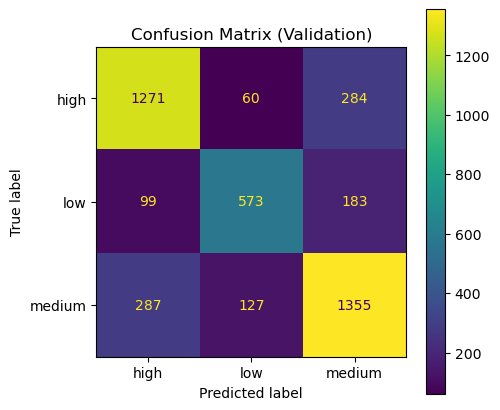

In [112]:
# === Confusion Matrix (Validation) - A1 (from saved ckpt or current model) ===
from pathlib import Path
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score

def find_project_root(start: Path) -> Path:
    for p in [start] + list(start.parents):
        if (p / "src").is_dir():
            return p
    return start

ROOT = find_project_root(Path.cwd().resolve())
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Project root:", ROOT)
print("Device:", device)

# ---- 1) 如果当前没有 model，就从 A1 保存文件加载 ----
if "model" not in globals():
    from src.model.bert_model import BertClassifier

    CKPT_PATH = ROOT / "src" / "model" / "bert_finetuned.pt"
    BASE_MODEL_DIR = ROOT / "src" / "model" / "distilbert-base-uncased"  # 你的离线模型目录

    assert CKPT_PATH.is_file(), f"Checkpoint not found: {CKPT_PATH}"
    assert BASE_MODEL_DIR.is_dir(), f"Base model dir not found: {BASE_MODEL_DIR}"

    ckpt = torch.load(CKPT_PATH, map_location=device)

    # 兼容你保存的格式：{'model_state_dict':..., 'id2label':..., 'num_classes':...}
    state_dict = ckpt["model_state_dict"] if isinstance(ckpt, dict) and "model_state_dict" in ckpt else ckpt

    # id2label/num_classes：优先用 ckpt 里的
    if isinstance(ckpt, dict) and "id2label" in ckpt:
        id2label = {int(k): v for k, v in ckpt["id2label"].items()}
    else:
        # 如果你没存 mapping，就手动在这里写
        id2label = {0: "low", 1: "medium", 2: "high"}

    num_classes = ckpt.get("num_classes", len(id2label)) if isinstance(ckpt, dict) else len(id2label)

    model = BertClassifier(
        model_name=str(BASE_MODEL_DIR),  # 离线加载本地 DistilBERT
        num_classes=num_classes,
        dropout=0.3,
        freeze_bert=False,
    ).to(device)

    model.load_state_dict(state_dict, strict=True)
    model.eval()
    print("Loaded model from:", CKPT_PATH)

else:
    # 如果你当前已经有 model，就确保 id2label/num_classes 存在
    if "id2label" not in globals():
        id2label = {0: "low", 1: "medium", 2: "high"}
    if "num_classes" not in globals():
        num_classes = len(id2label)

# ---- 2) 生成 y_true / y_pred（你说 04 里没定义，就在这里算）----
assert "val_loader" in globals(), "val_loader not found. 请先在 04 里运行到构建 val_loader 的 cell。"

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for batch in val_loader:
        # 兼容 batch 是 dict 的情况
        if isinstance(batch, dict):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch.get("attention_mask", None)
            if attention_mask is not None:
                attention_mask = attention_mask.to(device)
            labels = batch["labels"].to(device)
        else:
            # 兼容 batch 是 tuple/list 的情况: (input_ids, attention_mask, labels)
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device) if attention_mask is not None else None
            labels = labels.to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(logits, dim=1)

        y_true.extend(labels.cpu().numpy().tolist())
        y_pred.extend(preds.cpu().numpy().tolist())

# ---- 3) 画 confusion matrix + 打印 acc/macro-f1 ----
label_ids = sorted(list(id2label.keys()))
cm = confusion_matrix(y_true, y_pred, labels=label_ids)

acc = accuracy_score(y_true, y_pred)
macro_f1 = f1_score(y_true, y_pred, average="macro")
print(f"Validation Accuracy: {acc:.4f}")
print(f"Validation Macro-F1: {macro_f1:.4f}")

fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[id2label[i] for i in label_ids],
)
disp.plot(ax=ax, values_format="d")
plt.title("Confusion Matrix (Validation)")
plt.show()


,precision,recall,f1-score,support
high,0.767049,0.786997,0.776895,1615.0
low,0.753947,0.670175,0.709598,855.0
medium,0.743688,0.765969,0.754664,1769.0


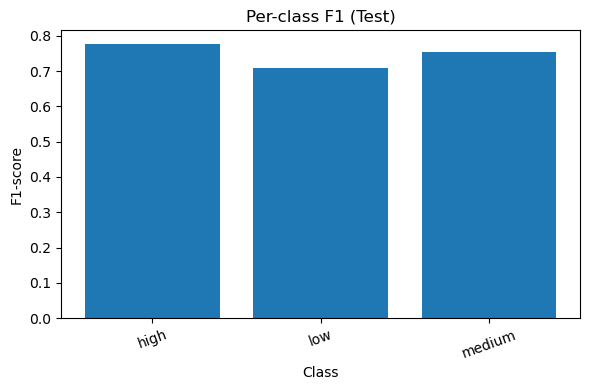

In [113]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# ====== 你需要确保这两个变量存在 ======
# y_true = [...]
# y_pred = [...]
# 可选：id2label = {0:"...", 1:"...", 2:"..."}  # 如果你有更好，没有也行

# 1) classification report（dict 形式方便转表）
report_dict = classification_report(
    y_true,
    y_pred,
    output_dict=True,
    zero_division=0
)

# 2) 转成表格（只保留每个类别的行）
df_report = pd.DataFrame(report_dict).T

# 如果你希望只看类别（排除 accuracy/macro avg/weighted avg）
# 类别行通常是 '0','1','2'（取决于你的 label 编码）
class_rows = [idx for idx in df_report.index if idx.isdigit()]
df_cls = df_report.loc[class_rows, ["precision", "recall", "f1-score", "support"]].copy()

# 3) 如果你有 id2label，把 index 替换成更可读的类别名
try:
    df_cls.index = [id2label[int(i)] for i in df_cls.index]
except Exception:
    pass

display(df_cls)

# 保存成 csv（可选）
df_cls.to_csv("per_class_report.csv", index=True)

# 4) Per-class F1 bar chart
plt.figure(figsize=(6,4))
plt.bar(df_cls.index.astype(str), df_cls["f1-score"])
plt.title("Per-class F1 (Test)")
plt.xlabel("Class")
plt.ylabel("F1-score")
plt.xticks(rotation=20)
plt.tight_layout()
plt.savefig("per_class_f1_bar.png", dpi=200)
plt.show()
